In [5]:
import pandas as pd
import numpy as np
attributes =['sepal length','sepal width','petal length','petal width','class']
IrisData = pd.read_csv('Iris.csv',sep=',',header=None,names = attributes,index_col = False)
by_class = IrisData.groupby('class')
classSetosaData = by_class.get_group('Iris-setosa')
classVirginicaData = by_class.get_group('Iris-virginica')
classVersicolorData = by_class.get_group('Iris-versicolor')
#ran1 = np.random.rand(len(classOneData)) < 0.8
#ran2 = np.random.rand(len(classZeroData)) < 0.8
trainClassSetosa = classSetosaData.sample(frac=0.8)
trainClassVirginica = classVirginicaData.sample(frac=0.8)
trainClassVersicolor = classVersicolorData.sample(frac=0.8)

valClassSetosa = classSetosaData.loc[~classSetosaData.index.isin(trainClassSetosa.index)]
valClassVirginica = classVirginicaData.loc[~classVirginicaData.index.isin(trainClassVirginica.index)]
valClassVersicolor = classVersicolorData.loc[~classVersicolorData.index.isin(trainClassVersicolor.index)]

train = pd.concat([trainClassSetosa,trainClassVirginica,trainClassVersicolor], ignore_index=True)
val = pd.concat([valClassSetosa,valClassVirginica,valClassVersicolor], ignore_index=True)
#train = pd.concat([classOneData[ran1], classZeroData[ran2]], ignore_index=True)
#val = pd.concat([classOneData[~ran1], classZeroData[~ran2]], ignore_index=True)
#train.to_csv('UsedTrainingDataForRobo1Ds',sep=' ',header=None,index = False)
#val.to_csv('UsedValidationDataForRobo1Ds',sep=' ',header=None,index = False)
#train.to_csv('UsedTrainingDataForIris.csv',sep=',',header=None,index = False)
#val.to_csv('UsedValidationDataForIris.csv',sep=',',header=None,index = False)
train = pd.read_csv('UsedTrainingDataForIris.csv',sep=',',header=None,names = attributes,index_col = False)
val = pd.read_csv('UsedValidationDataForIris.csv',sep=',',header=None,names = attributes,index_col = False)
#train = IrisData.sample(frac=0.8)
#val = IrisData.loc[~IrisData.index.isin(train.index)]
def  getDistBetweenPoints(Point1,Point2,method,parameter):
    #print(parameter)
    row1 = np.array(Point1[0:len(Point1)-1])
    row2 = np.array(Point2[0:len(Point1)-1])
    #print(row1)
    #print(row2)
    if method == 'Euclidean':
        #print("i am here hello")
        return (np.sum((np.abs(row1-row2))**2))**(1/2)
    elif method == 'Minkowski':
        return (np.sum(np.abs((row1-row2))**float(parameter)))**(1/float(parameter))
    elif method == 'Chebyshey':
        return np.max(np.abs(row1-row2))        
    elif method == 'Cosine':
        return 1-((sum((row1)*(row2)))/(np.sqrt(sum((row1)**2))*np.sqrt(sum((row2)**2))))
    elif method == 'Manhattan':
        return np.sum(np.abs(row1-row2))
    elif method == 'Mahalanobis':
        return 
    elif method == 'Hellinger':        
        return (1/np.sqrt(2))*np.sqrt(np.sum((np.abs(np.sqrt(row1)-np.sqrt(row2)))**2))
    elif method == 'Bray-Curtis':
        return sum(abs(row1-row2))/sum(abs(row1+row2))
    elif method == 'Canberra':
        return sum(abs(row1-row2))/sum(abs(row1)+abs(row2))
    elif method == 'Pearson':
        tempMeanRow1 = sum(row1) / float(len(row1))
        tempMeanRow2 = sum(row2) / float(len(row2))
        return 1-((sum((row1-tempMeanRow1)*(row2-tempMeanRow2)))/(np.sqrt(sum((row1-tempMeanRow1)**2))*np.sqrt(sum((row2-tempMeanRow2)**2))))

def getDistanceFromAllPoints(Point,distance_method,parameter):
    DistancesFromAllOtherPoints ={}
    for index,row in train.iterrows():
        DistancesFromAllOtherPoints[str(index)] = [getDistBetweenPoints(list(row),Point,distance_method,parameter),row[-1]]
    return DistancesFromAllOtherPoints

def getLabel(Point,distance_method,parameter,NumOfNeighbours):
    NearestNeighboursAndTheirDistances = {}  
    DistancesFromAllOtherPoints = getDistanceFromAllPoints(Point,distance_method,parameter)
    NearestNeighboursAndTheirDistances = dict(sorted(DistancesFromAllOtherPoints.items(), key=lambda e: e[1][0])[0:NumOfNeighbours])
      #print(len(DistancesFromAllOtherPoints))
    #print(NearestNeighboursAndTheirDistances)

    NumberOfClassZero = 0
    NumberOfClassOne = 0
    NumberOfClassTwo = 0
    #print(Point)
    #print(NearestNeighboursAndTheirDistances)
    
    for key, value in NearestNeighboursAndTheirDistances.items():
        if NearestNeighboursAndTheirDistances[key][1] == 'Iris-setosa':
            NumberOfClassZero += 1
        elif NearestNeighboursAndTheirDistances[key][1] == 'Iris-virginica':
            NumberOfClassOne += 1   
        else:
            NumberOfClassTwo += 1
    if(NumberOfClassZero>NumberOfClassOne):
        if(NumberOfClassZero>NumberOfClassTwo):
            return 'Iris-setosa'
        else:
            return 'Iris-versicolor'
    else:
        if(NumberOfClassOne>NumberOfClassTwo):
            return 'Iris-virginica'
        else:
            return 'Iris-versicolor'        
def compute(GivenDataSet,distance_method,parameter,NumOfNeighbours):
    GivenDataSet["predict"] = ['none']*len(GivenDataSet)
    for index,row in GivenDataSet.iterrows():
        predictedValue = getLabel(row.tolist(),distance_method,parameter,NumOfNeighbours)
        GivenDataSet.at[int(index),'predict'] = predictedValue
        #print(str(index)+")Actual Value is "+str(GivenDataSet.at[int(index),'class'])+" Predicted Value is "+str(predictedValue))
    #caluculate accuracy and precision
    #return GivenDataSet
def CalulatePrecsionRecallEtc(GivenTestData):
    conMatrix = np.zeros((3, 3))
    conMatrix = pd.crosstab(GivenDataSet["class"],GivenDataSet["predict"])
    accuracy = 0
    totalSum = 0
    ColumnSumSetosa = 0
    ColumnSumVersicolor = 0
    ColumnSumVirginica = 0
    RowSumSetosa = 0
    RowSumVersicolor = 0
    RowSumVirginica = 0
    for (x,y), value in np.ndenumerate(conMatrix):
        if x==y:
            accuracy += value    
        totalSum+=value
        if x == 0:#'Iris-setosa':
            RowSumSetosa += value
        elif x == 1:#'Iris-versicolor':
            RowSumVersicolor += value
        elif x == 2:#'Iris-virginica':
            RowSumVirginica += value
        if y == 0:#'Iris-setosa':
            ColumnSumSetosa += value
        elif y == 1:#'Iris-versicolor':
            ColumnSumVersicolor += value
        elif y == 2:#'Iris-virginica':
            ColumnSumVirginica += value
    #print(RowSumSetosa)
    accuracy /=totalSum 
    precisionSetosa = conMatrix['Iris-setosa']['Iris-setosa']/ColumnSumSetosa
    precisionVersicolor = conMatrix['Iris-versicolor']['Iris-versicolor']/ColumnSumVersicolor
    precisionVirginica = conMatrix['Iris-virginica']['Iris-virginica']/ColumnSumVirginica
    recallSetosa = conMatrix['Iris-setosa']['Iris-setosa']/RowSumSetosa
    recallVersicolor = conMatrix['Iris-versicolor']['Iris-versicolor']/RowSumVersicolor
    recallVirginica = conMatrix['Iris-virginica']['Iris-virginica']/RowSumVirginica
    precision =  (precisionSetosa+precisionVersicolor+precisionVirginica)/3
    recall = (recallSetosa + recallVersicolor+recallVirginica)/3  
    F1_Score = 2*((1/recall)+(1/precision))
    
    print("Results On GivenTestData")
    print("-------------------------------------------------")   
    print("Precsion is          "+str(precision))
    print("Recall is            "+str(recall))
    print("F1_Score is          "+str(F1_Score))
    print("Accuracy is          "+str(accuracy))
    print("-------------------------------------------------")

def getAccuracy(GivenTestData):
    conMatrix = np.zeros((3, 3))
    conMatrix = pd.crosstab(GivenDataSet["class"],GivenDataSet["predict"])
    accuracy = 0
    totalSum = 0
    for (x,y), value in np.ndenumerate(conMatrix):
        if x==y:
            accuracy += value    
        totalSum+=value
    accuracy /=totalSum 
    return accuracy
    

NumOfNeighbours = 3
distance_method = 'Cosine'
#'Euclidean' 'Minkowski' 'Chebyshey''Cosine''Manhattan' 'Mahalanobis' 'Hellinger''Bray-Curtis' 'Canberra''Pearson'
parameter = 0.5
#import sys
#filename = sys.argv[1]
#GivenDataSet = pd.read_csv(filename,sep=',',header=None,names = attributes,index_col = False)
GivenDataSet = val.copy()
compute(GivenDataSet,distance_method,parameter,NumOfNeighbours)
CalulatePrecsionRecallEtc(GivenDataSet)
#GivenDataSet


Results On GivenTestData
-------------------------------------------------
Precsion is          1.0
Recall is            1.0
F1_Score is          4.0
Accuracy is          1.0
-------------------------------------------------


In [6]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
dictOfMeasures ={}
distanceMeasures = ['Euclidean','Minkowski','Chebyshey','Cosine','Manhattan','Hellinger','Bray-Curtis','Canberra','Pearson']
for j in distanceMeasures:
    dictOfMeasures[j] = []
    for i in range(1,25):       
        NumOfNeighbours = i
        distance_method = j
        parameter = 0.5
        GivenDataSet = val.copy()
        compute(GivenDataSet,distance_method,parameter,NumOfNeighbours)
        dictOfMeasures[j].append(getAccuracy(GivenDataSet))    

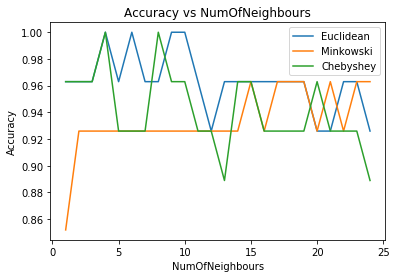

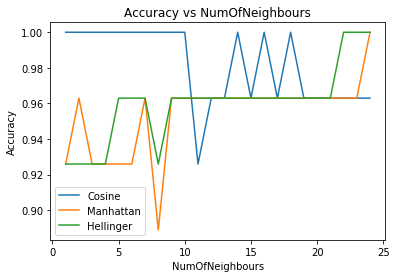

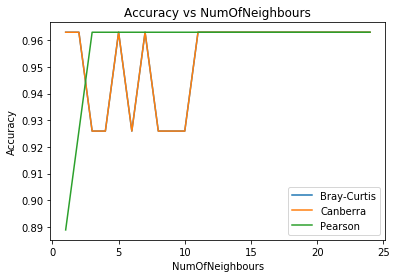

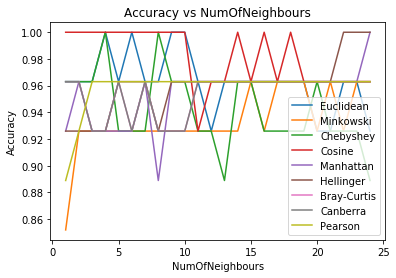

In [7]:
fig, ax = plt.subplots()
for j in distanceMeasures[0:3]:
    ax.plot(list(range(1,25)),dictOfMeasures[j], label=j)
ax.legend(loc=0) # upper left corner
ax.set_xlabel('NumOfNeighbours')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy vs NumOfNeighbours');
fig, ax = plt.subplots()
for j in distanceMeasures[3:6]:
    ax.plot(list(range(1,25)),dictOfMeasures[j], label=j)
ax.legend(loc=0) # upper left corner
ax.set_xlabel('NumOfNeighbours')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy vs NumOfNeighbours');
fig, ax = plt.subplots()
for j in distanceMeasures[6:10]:
    ax.plot(list(range(1,25)),dictOfMeasures[j], label=j)
ax.legend(loc=0) # upper left corner
ax.set_xlabel('NumOfNeighbours')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy vs NumOfNeighbours');
fig, ax = plt.subplots()
for j in distanceMeasures:
    ax.plot(list(range(1,25)),dictOfMeasures[j], label=j)
ax.legend(loc=0) # upper left corner
ax.set_xlabel('NumOfNeighbours')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy vs NumOfNeighbours');

In [3]:
conMatrix = pd.crosstab(GivenDataSet["class"],GivenDataSet["predict"])

In [4]:
conMatrix

predict,Iris-setosa,Iris-versicolor,Iris-virginica
class,,,
Iris-setosa,9,0,0
Iris-versicolor,0,8,1
Iris-virginica,0,0,9
